# Description

This notebook performs cross-vendor QA checks to compare CCXT and CryptoChassis futures data in terms of:
   - Difference and intersection of vendor universes
   - Time intervals, i.e. which vendor has the longest data available for each full symbol in intersecting universe
   - Data quality (bad data [%], missing bars [%], volume=0 [%], NaNs [%]) for intersecting universe and time intervals

# Imports

In [1]:
import logging
import os

import core.config.config_ as cconconf
import core.config.config_utils as ccocouti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import helpers.hs3 as hs3
import im_v2.ccxt.data.client as icdcl
import im_v2.crypto_chassis.data.client as iccdc
import research_amp.cc.qa as ramccqa

/app/helpers/hparquet.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-165bd745-f452-419d-a12f-3281801f0c27.json'
INFO  # Git
    branch_name='master'
    hash='20a642966'
    # Last commits:
      * 20a642966 DanilYachmenev CmTask2188: add notebook (#2206)                                  ( 5 minutes ago) Fri Jun 24 14:02:07 2022  (HEAD -> master, origin/master, origin/HEAD)
      * 6d009bb19 Daniil Tikhomirov CMTask2188: Fix options (#2207)                                   (  16 hours ago) Thu Jun 23 22:11:06 2022           
      * bb5612f77 Max Sergeychikov CMTask2190 - Extract new iteration of e-mail reaches (#2194)      (  17 hours ago) Thu Jun 23 21:25:42 2022           
# Machine info
    system=Linux
    node name=488f35b9b513
    release=5.13.0-1022-aws
    version=#24~20.04.1-Ubuntu SMP Thu Apr 7 22:10:15 UTC 2022
    machine=x86_64
    processor=x86_64
    cpu count=8
    cpu freq=scpufreq(current=2499.998, min=0.0, max=0.0)
    m

# Configs

In [11]:
def get_cmtask2188_config() -> cconconf.Config:
    """
    Get task specific config.
    """
    config = cconconf.Config()
    param_dict = {
        "data": {
            "ccxt": {
                "universe_version": "v5",
                "resample_1min": False,
                "root_dir": os.path.join(
                    hs3.get_s3_bucket_path("ck"), "reorg", "historical.manual.pq"
                ),
                "partition_mode": "by_year_month",
                "dataset": "ohlcv",
                "contract_type": "futures",
                "data_snapshot": "20220620",
                "aws_profile": "ck",
            },
            "crypto_chassis": {
                "universe_version": "v2",
                "resample_1min": False,
                "root_dir": os.path.join(
                    hs3.get_s3_bucket_path("ck"), "reorg", "historical.manual.pq"
                ),
                "partition_mode": "by_year_month",
                "dataset": "ohlcv",
                "contract_type": "futures",
                "data_snapshot": "20220620",
                "aws_profile": "ck",
            },
            # Parameters for data query.
            "read_data": {
                "start_ts": None,
                "end_ts": None,
                "columns": ["full_symbol", "close", "volume"],
                "filter_data_mode": "assert",
            },
        },
        "column_names": {
            "full_symbol": "full_symbol",
            "close_price": "close",
        },
        "stats": {
            "threshold": 30,
        },
    }
    config = cconfig.Config.from_dict(param_dict)
    return config

In [12]:
config = get_cmtask2188_config()
print(config)

data:
  ccxt:
    universe_version: v5
    resample_1min: False
    root_dir: s3://cryptokaizen-data/reorg/historical.manual.pq
    partition_mode: by_year_month
    dataset: ohlcv
    contract_type: futures
    data_snapshot: 20220620
    aws_profile: ck
  crypto_chassis:
    universe_version: v2
    resample_1min: False
    root_dir: s3://cryptokaizen-data/reorg/historical.manual.pq
    partition_mode: by_year_month
    dataset: ohlcv
    contract_type: futures
    data_snapshot: 20220620
    aws_profile: ck
  read_data:
    start_ts: None
    end_ts: None
    columns: ['full_symbol', 'close', 'volume']
    filter_data_mode: assert
column_names:
  full_symbol: full_symbol
  close_price: close
stats:
  threshold: 30


# Compare universes

In [13]:
crypto_chassis_client = iccdc.CryptoChassisHistoricalPqByTileClient(
    **config["data"]["crypto_chassis"]
)
ccxt_client = icdcl.CcxtHistoricalPqByTileClient(**config["data"]["ccxt"])

In [26]:
# We have futures data only for Binance.
crypto_chassis_universe = [
    full_symbol
    for full_symbol in crypto_chassis_client.get_universe()
    if full_symbol.startswith("binance")
]
ccxt_universe = [
    full_symbol
    for full_symbol in ccxt_client.get_universe()
    if full_symbol.startswith("binance")
]

In [27]:
common_universe = list(set(crypto_chassis_universe) & set(ccxt_universe))

In [28]:
compare_universe = hprint.set_diff_to_str(
    crypto_chassis_universe, ccxt_universe, add_space=True
)
print(compare_universe)

* obj1: (7) binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::EOS_USDT binance::ETH_USDT binance::SOL_USDT

* obj2: (9) binance::ADA_USDT binance::AVAX_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::EOS_USDT binance::ETH_USDT binance::LINK_USDT binance::SOL_USDT

* intersect=(7) binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::EOS_USDT binance::ETH_USDT binance::SOL_USDT

* obj1-obj2=(0) 

* obj2-obj1=(2) binance::AVAX_USDT binance::LINK_USDT



# Compare QA stats

In [29]:
ccxt_binance_data = ccxt_client.read_data(
    common_universe, **config["data"]["read_data"]
)
ccxt_binance_data.head(3)

,full_symbol,close,volume
timestamp,,,
2019-09-08 17:57:00+00:00,binance::BTC_USDT,10000.0,0.001
2019-09-08 17:58:00+00:00,binance::BTC_USDT,10000.0,0.000
2019-09-08 17:59:00+00:00,binance::BTC_USDT,10000.0,0.001


In [30]:
crypto_chassis_binance_data = crypto_chassis_client.read_data(
    common_universe, **config["data"]["read_data"]
)
crypto_chassis_binance_data.head(3)

,full_symbol,close,volume
timestamp,,,
2021-08-07 00:00:00+00:00,binance::ADA_USDT,1.4018,236179.000
2021-08-07 00:00:00+00:00,binance::BNB_USDT,341.9400,1240.180
2021-08-07 00:00:00+00:00,binance::BTC_USDT,42790.2900,599.745


In [31]:
crypto_chassis_vendor = "Crypto Chassis"
crypto_chassis_timestamp_binance_stats = ramccqa.get_timestamp_stats(
    crypto_chassis_binance_data, crypto_chassis_vendor
)
ccxt_vendor = "CCXT"
ccxt_timestamp_binance_stats = ramccqa.get_timestamp_stats(
    ccxt_binance_data, ccxt_vendor
)
#
binance_timestamp_stats_qa = ramccqa.compare_data_stats(
    crypto_chassis_timestamp_binance_stats,
    ccxt_timestamp_binance_stats,
)
binance_timestamp_stats_qa

min_timestamp                                       max_timestamp                           days_available      
                              Crypto Chassis                      CCXT            Crypto Chassis                      CCXT Crypto Chassis  CCXT
binance::ADA_USDT  2021-08-07 00:00:00+00:00 2020-01-31 08:01:00+00:00 2022-06-19 23:59:00+00:00 2022-06-24 00:18:00+00:00            316   874
binance::BNB_USDT  2021-08-07 00:00:00+00:00 2020-02-10 08:01:00+00:00 2022-06-19 23:59:00+00:00 2022-06-24 01:39:00+00:00            316   864
binance::BTC_USDT  2021-08-07 00:00:00+00:00 2019-09-08 17:57:00+00:00 2022-06-19 23:59:00+00:00 2022-06-24 01:39:00+00:00            316  1019
binance::DOGE_USDT 2021-08-07 00:00:00+00:00 2020-07-10 09:00:00+00:00 2022-06-19 23:59:00+00:00 2022-06-24 01:39:00+00:00            316   713
binance::EOS_USDT  2021-08-07 00:00:00+00:00 2020-01-08 08:00:00+00:00 2022-06-19 23:59:00+00:00 2022-06-24 01:39:00+00:00            316   897
binance::ETH_USDT  2021-08-07 00:00:00+00:00 2019-11-27 07:45:00+00:00 2022-06-19 23:59:00+00:00 2022-06-24 01:39:00+00:00            316   939
binance::SOL_USDT  2021-10-13 17:49:00+00:00 2020-09-14 07:00:00+00:00 2022-06-19 23:59:00+00:00 2022-06-24 01:39:00+00:00            249   647

In [32]:
agg_level_full_symbol = ["full_symbol"]
crypto_chassis_bad_data_binance_stats = ramccqa.get_bad_data_stats(
    crypto_chassis_binance_data, agg_level_full_symbol, crypto_chassis_vendor
)
ccxt_bad_data_binance_stats = ramccqa.get_bad_data_stats(
    ccxt_binance_data, agg_level_full_symbol, ccxt_vendor
)
#
binance_bad_data_stats_qa = ramccqa.compare_data_stats(
    crypto_chassis_bad_data_binance_stats,
    ccxt_bad_data_binance_stats,
)
binance_bad_data_stats_qa

bad data [%]           missing bars [%]             volume=0 [%]                 NaNs [%]     
                   Crypto Chassis      CCXT   Crypto Chassis      CCXT Crypto Chassis      CCXT Crypto Chassis CCXT
binance::ADA_USDT        0.242508  0.533211         0.242508  0.000000            0.0  0.533211            0.0  0.0
binance::BNB_USDT        0.058053  0.063684         0.058053  0.000000            0.0  0.063684            0.0  0.0
binance::BTC_USDT        0.047976  0.031952         0.047976  0.000068            0.0  0.031884            0.0  0.0
binance::DOGE_USDT       0.055862  1.368758         0.055862  0.000000            0.0  1.368758            0.0  0.0
binance::EOS_USDT        0.050166  0.012377         0.050166  0.000000            0.0  0.012377            0.0  0.0
binance::ETH_USDT        0.053233  0.029042         0.053233  0.000000            0.0  0.029042            0.0  0.0
binance::SOL_USDT        0.258267  0.034627         0.258267  0.000000            0.0  0.034627            0.0  0.0

In [33]:
agg_level_full_symbol_year_month = ["full_symbol", "year", "month"]
crypto_chassis_bad_data_binance_stats_by_year_month = ramccqa.get_bad_data_stats(
    crypto_chassis_binance_data,
    agg_level_full_symbol_year_month,
    crypto_chassis_vendor,
)
ccxt_bad_data_binance_stats_by_year_month = ramccqa.get_bad_data_stats(
    ccxt_binance_data, agg_level_full_symbol_year_month, ccxt_vendor
)
#
binance_bad_data_stats_by_year_month_qa = ramccqa.compare_data_stats(
    crypto_chassis_bad_data_binance_stats_by_year_month,
    ccxt_bad_data_binance_stats_by_year_month,
)
binance_bad_data_stats_by_year_month_qa

bad data [%]           missing bars [%]        volume=0 [%]                 NaNs [%]     
                           Crypto Chassis      CCXT   Crypto Chassis CCXT Crypto Chassis      CCXT Crypto Chassis CCXT
binance::ADA_USDT  2021 8        0.008333  0.000000         0.008333  0.0            0.0  0.000000            0.0  0.0
                        9        0.118056  0.000000         0.118056  0.0            0.0  0.000000            0.0  0.0
                        10       0.483871  0.000000         0.483871  0.0            0.0  0.000000            0.0  0.0
                        11       0.025463  0.000000         0.025463  0.0            0.0  0.000000            0.0  0.0
                        12       0.000000  0.000000         0.000000  0.0            0.0  0.000000            0.0  0.0
                   2022 1        0.000000  0.000000         0.000000  0.0            0.0  0.000000            0.0  0.0
                        2        0.000000  0.000000         0.000000  0.0            0.0  0.000000            0.0  0.0
                        3        0.000000  0.000000         0.000000  0.0            0.0  0.000000            0.0  0.0
                        4        1.703704  0.000000         1.703704  0.0            0.0  0.000000            0.0  0.0
                        5        0.201613  0.143369         0.201613  0.0            0.0  0.143369            0.0  0.0
                        6        0.000000  0.000000         0.000000  0.0            0.0  0.000000            0.0  0.0
binance::BNB_USDT  2021 8        0.008333  0.000000         0.008333  0.0            0.0  0.000000            0.0  0.0
                        9        0.120370  0.000000         0.120370  0.0            0.0  0.000000            0.0  0.0
                        10       0.259857  0.000000         0.259857  0.0            0.0  0.000000            0.0  0.0
                        11       0.002315  0.000000         0.002315  0.0            0.0  0.000000            0.0  0.0
                        12       0.000000  0.000000         0.000000  0.0            0.0  0.000000            0.0  0.0
                   2022 1        0.000000  0.000000         0.000000  0.0            0.0  0.000000            0.0  0.0
                        2        0.000000  0.000000         0.000000  0.0            0.0  0.000000            0.0  0.0
                        3        0.064964  0.000000         0.064964  0.0            0.0  0.000000            0.0  0.0
                        4        0.000000  0.000000         0.000000  0.0            0.0  0.000000            0.0  0.0
                        5        0.143369  0.143369         0.143369  0.0            0.0  0.143369            0.0  0.0
                        6        0.000000  0.000000         0.000000  0.0            0.0  0.000000            0.0  0.0
binance::BTC_USDT  2021 8        0.008333  0.000000         0.008333  0.0            0.0  0.000000            0.0  0.0
                        9        0.148148  0.000000         0.148148  0.0            0.0  0.000000            0.0  0.0
                        10       0.194892  0.000000         0.194892  0.0            0.0  0.000000            0.0  0.0
                        11       0.002315  0.000000         0.002315  0.0            0.0  0.000000            0.0  0.0
                        12       0.000000  0.000000         0.000000  0.0            0.0  0.000000            0.0  0.0
                   2022 1        0.000000  0.000000         0.000000  0.0            0.0  0.000000            0.0  0.0
                        2        0.000000  0.000000         0.000000  0.0            0.0  0.000000            0.0  0.0
                        3        0.000000  0.000000         0.000000  0.0            0.0  0.000000            0.0  0.0
                        4        0.000000  0.000000         0.000000  0.0            0.0  0.000000            0.0  0.0
                        5        0.143369  0.143369         0.143369  0.0            0.0  0.143369    

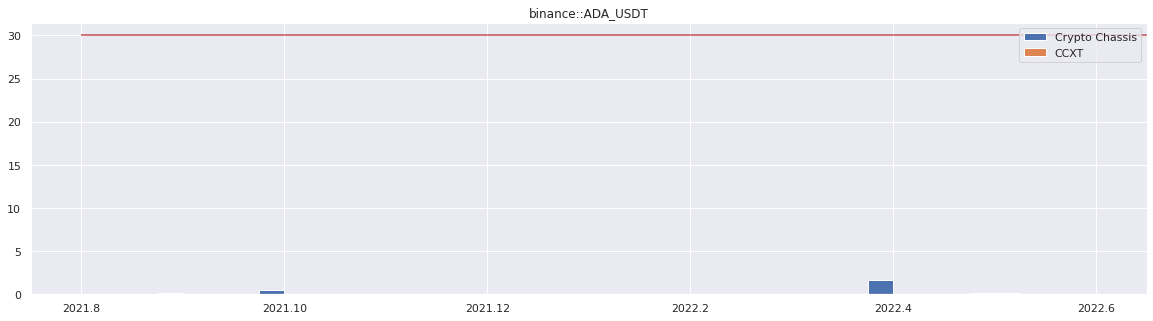

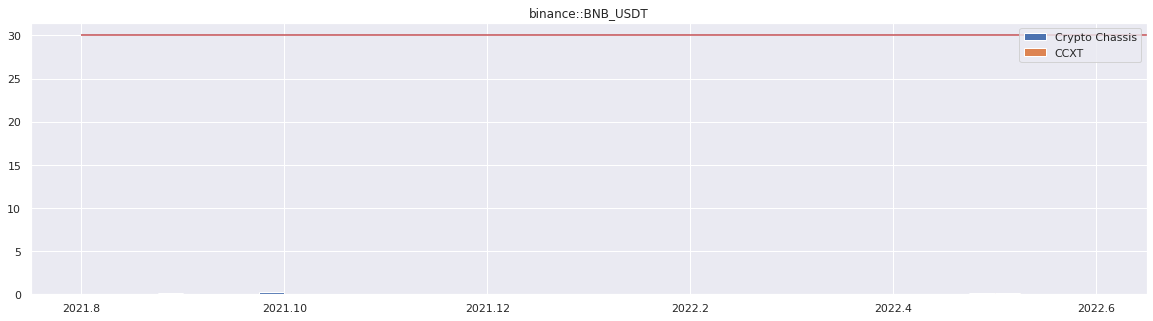

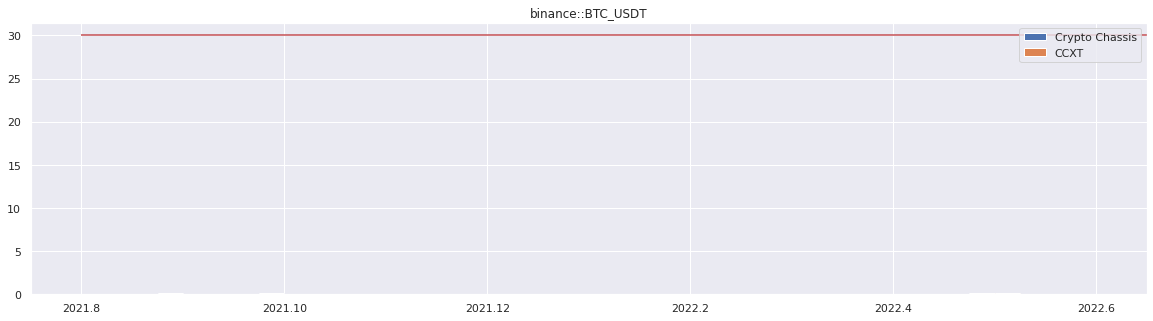

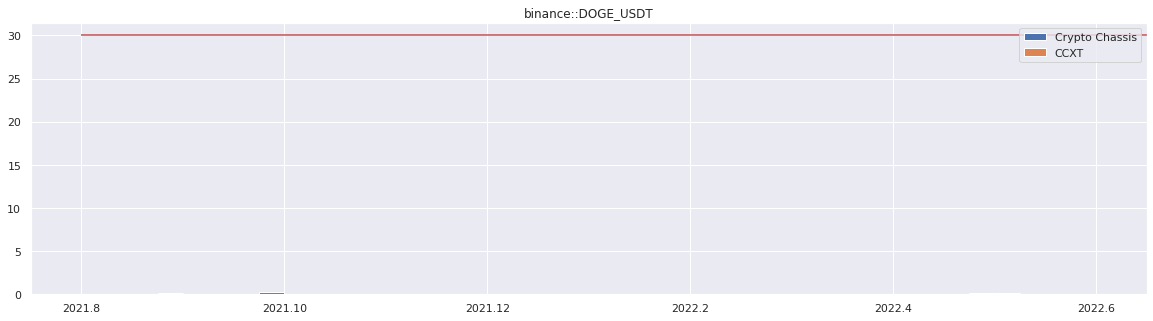

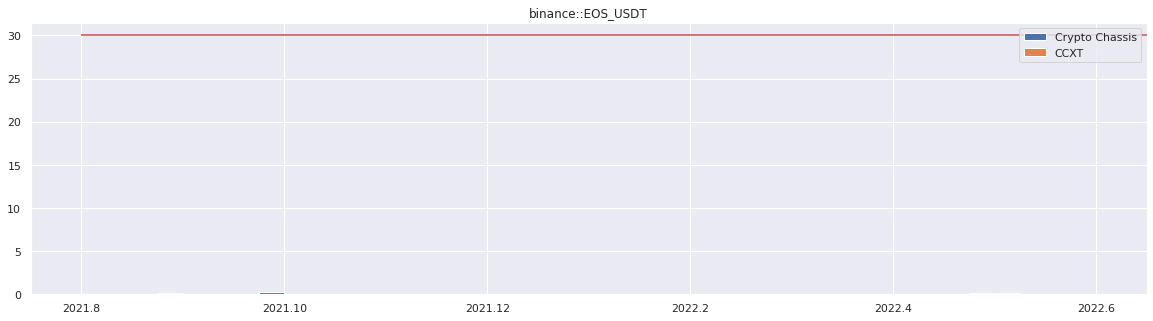

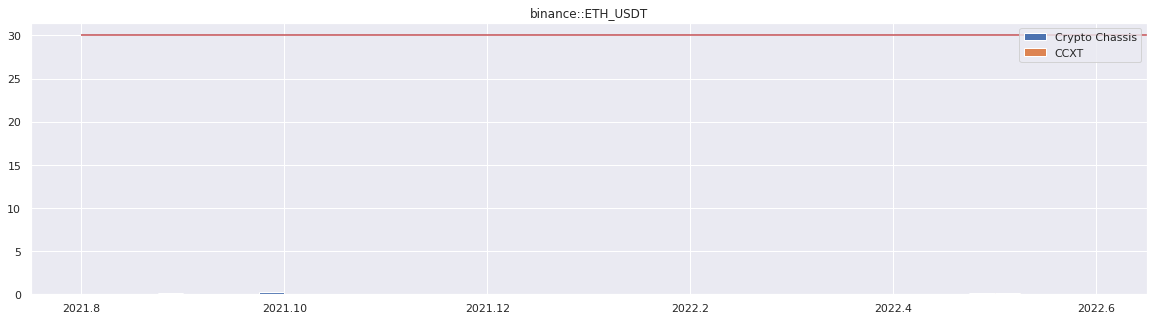

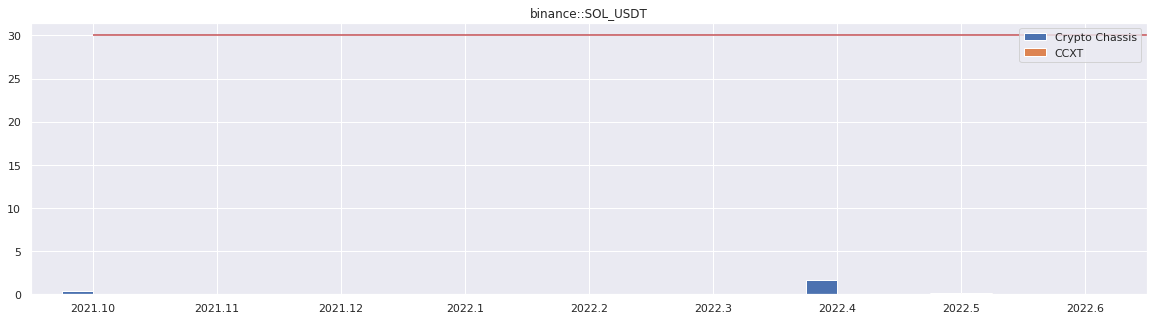

In [34]:
ramccqa.plot_bad_data_by_year_month_stats(
    binance_bad_data_stats_by_year_month_qa, config["stats"]["threshold"]
)